In [1]:
import colorplot as cp

In [2]:
net, train_producer = cp._setup(
    label_path   = 'data/raw/training2017/REFERENCE.csv',
    data_path    = 'data/raw/training2017/',
    weights_path = 'dry/saved/EncdedWideResnetFIXED/state_dict_highscore'
)
dataiter = iter(train_producer)

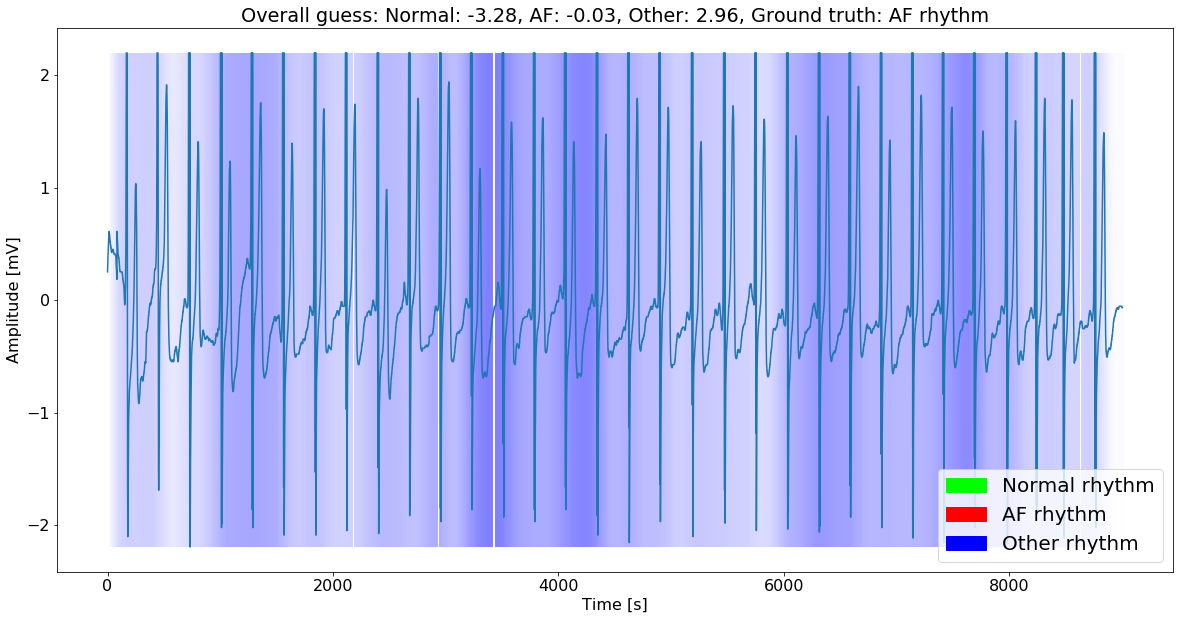

[-3.19040751 -0.06854653  2.90799022]


In [7]:
dataiter = iter(train_producer)
raw_data = next(dataiter)
data = raw_data['x']['time'].data.cpu().numpy()[0][0]
raw_logit = net.forward(raw_data['x'], avg=False).data.cpu().numpy()[0]
class_dict = ['Normal rhythm', 'AF rhythm', 'Other rhythm']
label = class_dict[raw_data['y'].data.cpu().numpy()[0]]
guess = net.forward(raw_data['x'], avg=True).data.cpu().numpy()[0]
cp.colorplot(data, raw_logit, label)
print(guess)

# Prototyping

In [1]:
import torch as th
from torch.autograd import Variable

import data_handler
import dilated_model as DM
import trainer as T

import numpy as np
from scipy import signal, ndimage
import sys, os
from os.path import basename, splitext

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 10]
font = {'size': 16}
matplotlib.rc('font', **font)

th.multiprocessing.set_sharing_strategy('file_system')
name = splitext(basename(sys.argv[0]))[0]

global_transforms = [
    data_handler.Crop(9000),
]

transformationsA = [
    data_handler.Threshold(sigma=2.2),
    data_handler.RandomMultiplier(-1),
]

transformationsB = [
    data_handler.RandomMultiplier(-1),
    data_handler.Spectogram(31)
]

dataset = data_handler.DataSet(
    'data/raw/training2017/REFERENCE.csv', data_handler.load_forked,
    global_transforms=global_transforms,
    fork_transforms={'time':transformationsA, 'freq':transformationsB},
    path='data/raw/training2017/',
    remove_unlisted=False, tokens=data_handler.atrif_tokens, remove_noise=True)
train_set, eval_set = dataset.disjunct_split(.9)
train_producer = th.utils.data.DataLoader(
    dataset=dataset, batch_size=5, shuffle=True,
    num_workers=0, collate_fn=data_handler.batchify_forked)

In [2]:
timeNet = DM.EncodeWideResNetFIXED(in_channel=1, init_channel=16, 
    num_enc_layer=4, N_res_in_block=1, use_selu=True)

freqNet = DM.SkipFCN(in_channel=16, use_selu=True,
    channels=[16,16,  32,32,  64,64,64,  128,128,128,  128,128,128])

classifier = th.nn.Sequential(th.nn.BatchNorm1d(256), DM.SELU(), th.nn.Conv1d(256, 3, 1))
net = DM.CombinedTransform(
    pretrained=False,
    feature_length=20, 
    time=timeNet, 
    freq=freqNet, 
    classifier=classifier)
net.load_state_dict(th.load('dry/saved/EncdedWideResnetFIXED/state_dict_highscore'))

In [3]:
dataiter = iter(train_producer)

In [8]:
raw_data = next(dataiter)
raw_logit = net.forward(raw_data['x'], avg=False).data.cpu().numpy()[0]
decision = np.average(raw_logit, axis=1)
class_dict = ['Normal rhythm', 'AF rhythm', 'Other rhythm']
label = class_dict[raw_data['y'].data.cpu().numpy()[0]]
print(decision, label)

[-0.14217825 -3.89514637  3.99044585] AF rhythm


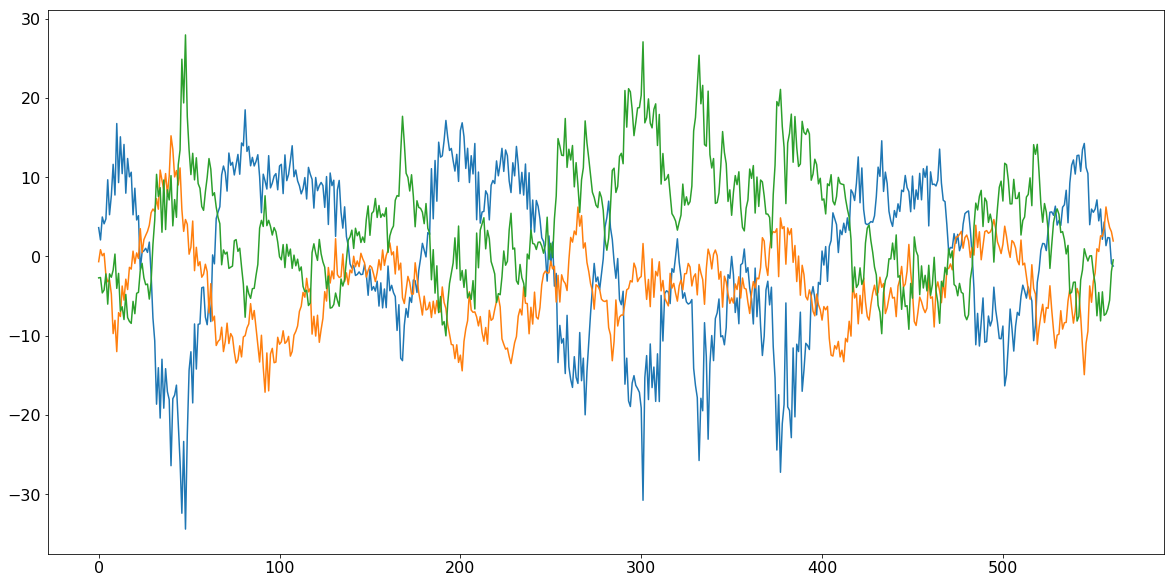

In [9]:
plt.plot(np.transpose(raw_logit))
plt.show()

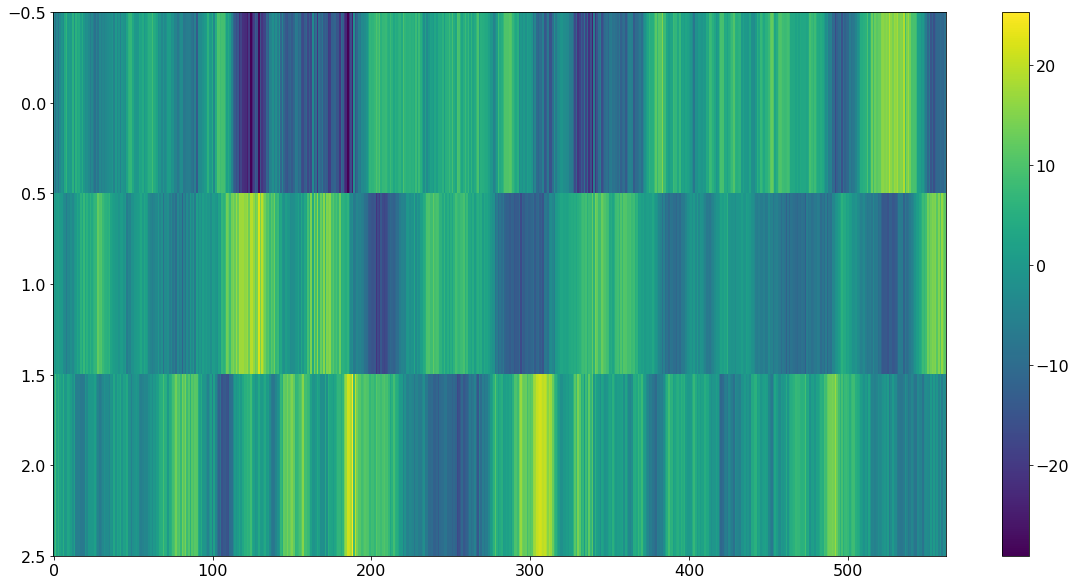

In [13]:
plt.imshow(raw_logit, aspect='auto', interpolation='None')
plt.colorbar()
plt.show()

In [14]:
data = raw_data['x']['time'].data.cpu().numpy()[0][0]

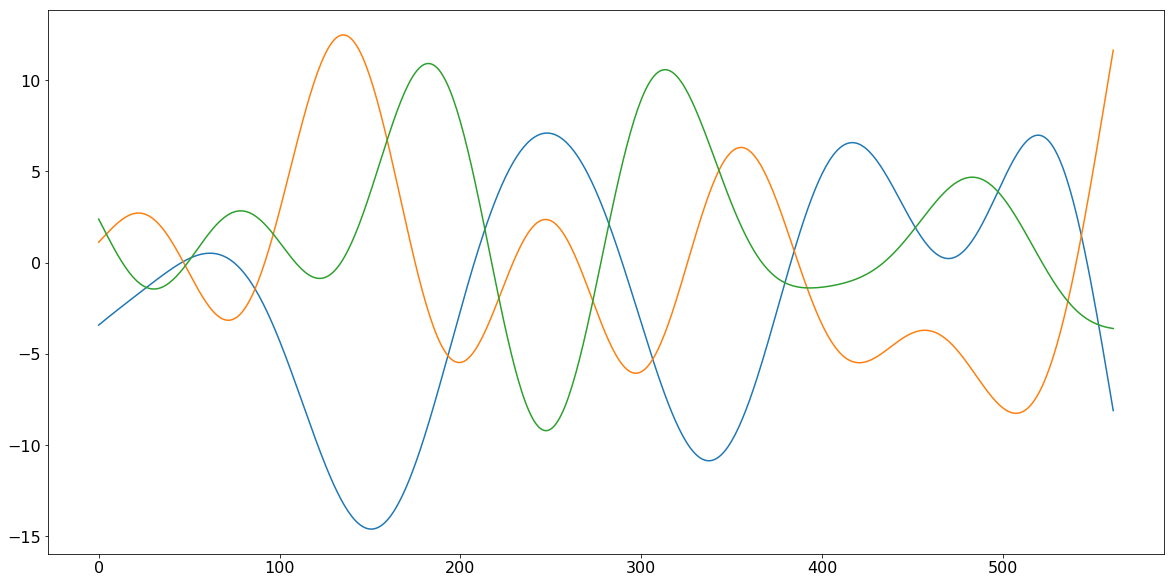

In [39]:
def gauss(n=11,sigma=1):
    r = range(-int(n/2),int(n/2)+1)
    return [1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-float(x)**2/(2*sigma**2)) for x in r]

#window = gauss(150, sigma=20)
#print(sum(window))
#avg_logit = ndimage.convolve1d(np.transpose(raw_logit), window, axis=0)
b, a = signal.butter(8, 0.02)
avg_logit = signal.filtfilt(b, a, np.transpose(raw_logit), axis=0, padlen=150)
plt.plot(avg_logit)
plt.show()

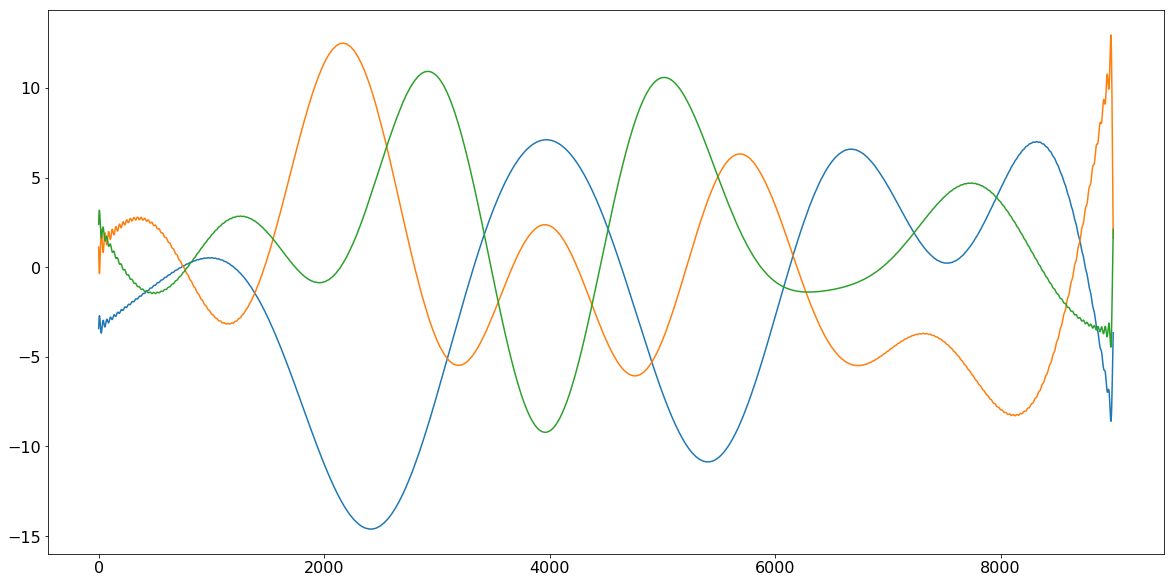

In [40]:
streched_logit = signal.resample(avg_logit,len(data), axis=0)
plt.plot(streched_logit)
plt.show()

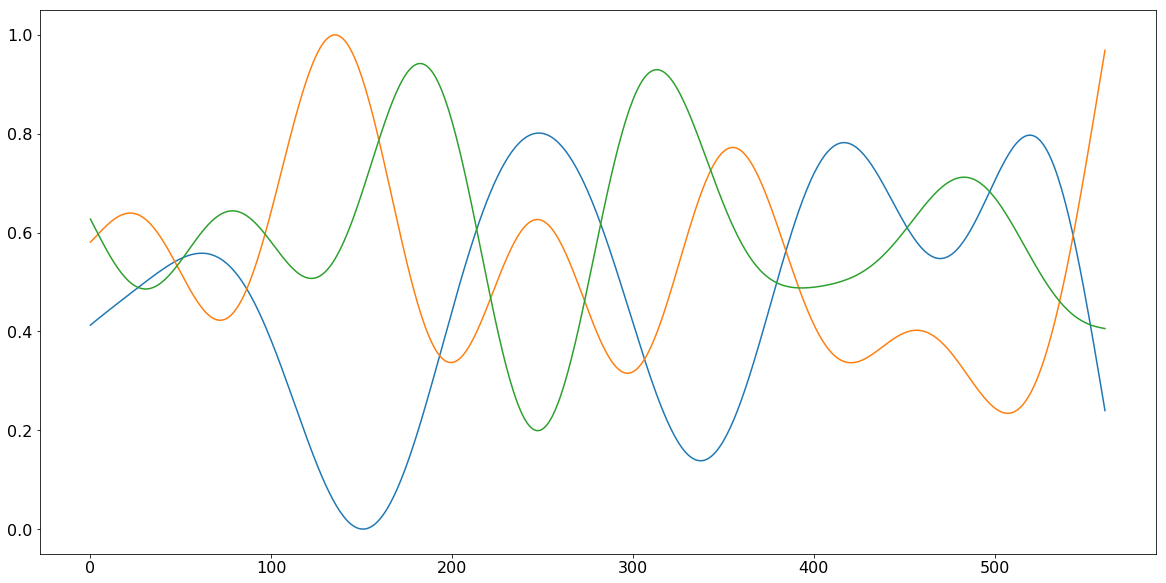

In [41]:
pre_norm = avg_logit - np.min(avg_logit)
pre_norm = pre_norm / np.max(pre_norm)
#b, a = signal.butter(8, 0.006)
#filt_logit = signal.filtfilt(b, a, pre_norm, axis=0, padlen=150)
plt.plot(pre_norm)
plt.show()

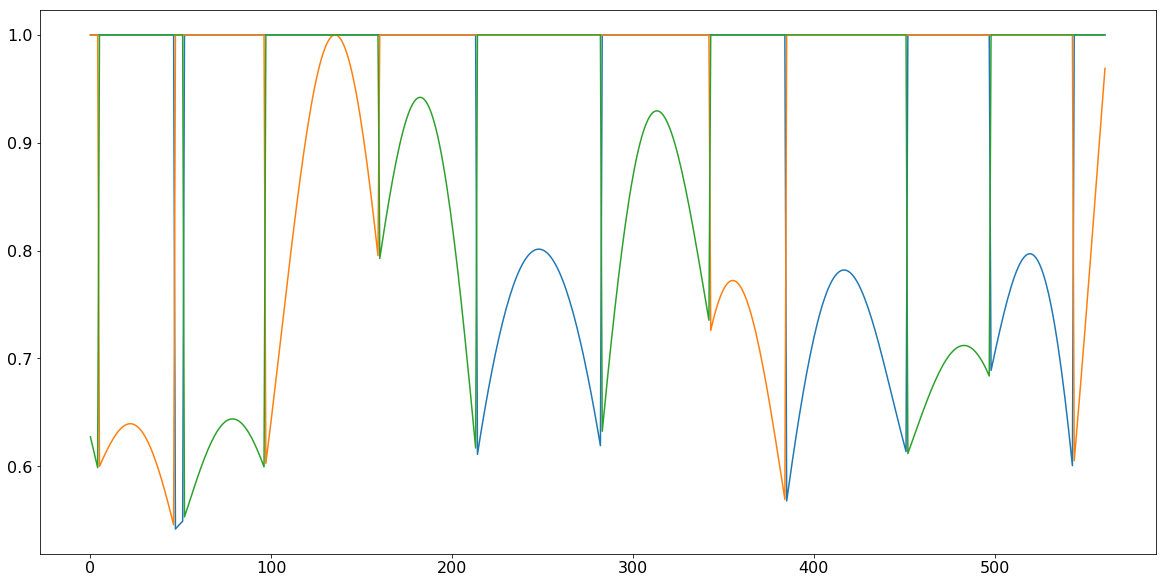

In [42]:
indices = np.argmax(pre_norm, axis=1)
one_hot = np.eye(3)[indices]
selected_logit = np.where(one_hot == 1, pre_norm, 1)
plt.plot(selected_logit)
plt.show()

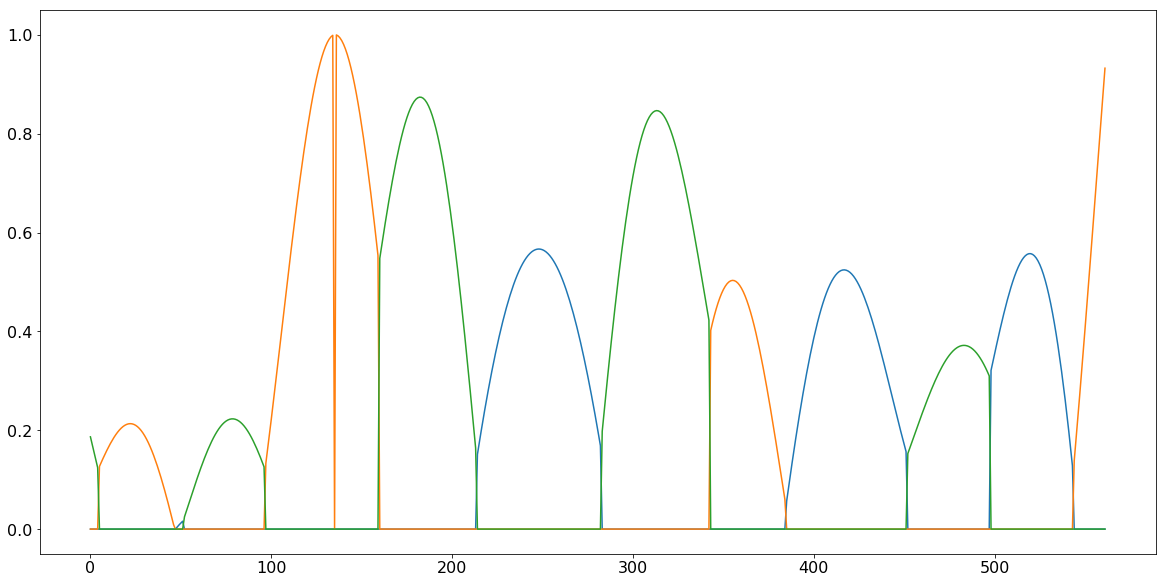

In [43]:
minimum = np.min(selected_logit)
norm_logit = selected_logit - minimum
norm_logit = np.where(norm_logit == 1 - minimum, 0, norm_logit)
norm_logit = norm_logit / np.max(norm_logit)
plt.plot(norm_logit)
plt.show()

coloring started!
coloring is ready!


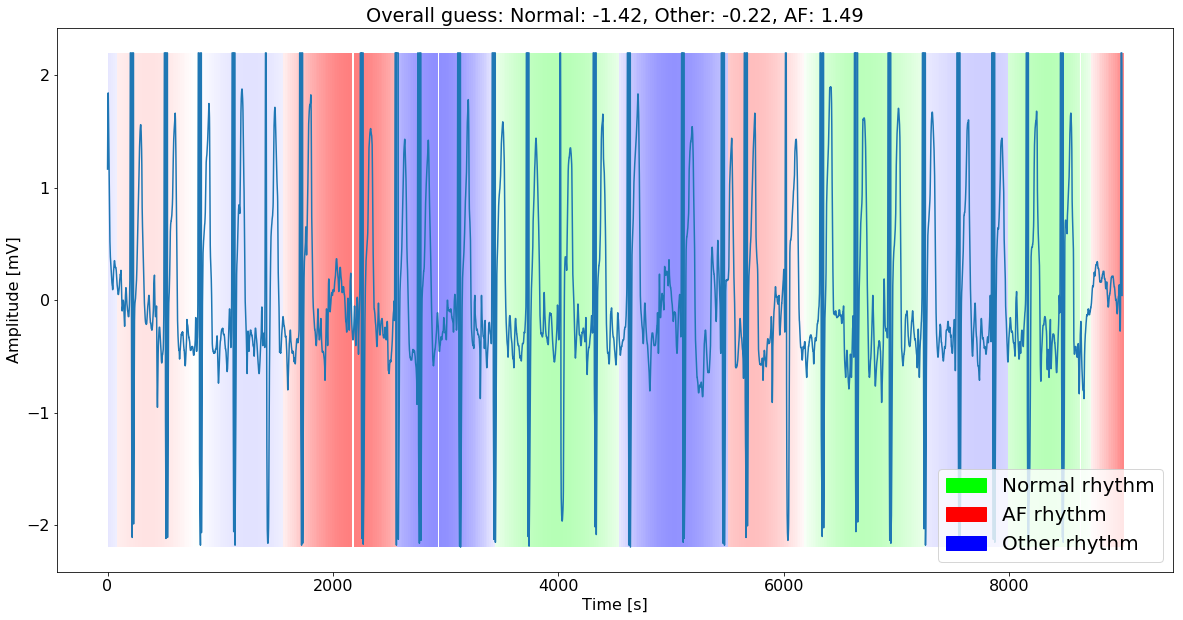

In [44]:
def convert(float):
    return round(float*255.).astype(int)
def convertArray(array):
    return ((convert(array[0]), convert(array[1]), convert(array[2])))

fig = plt.figure()
ax = fig.add_subplot(111)
data_length = len(data)
t = np.linspace(0, data_length, data_length)
ax.plot(t, data)

logit = np.transpose(norm_logit)
color = [[],[],[]]
color[0] = 1 - logit[0] - logit[2]
color[1] = 1 - logit[1] - logit[2]
color[2] = 1 - logit[0] - logit[1]
color = np.transpose(color)

print("coloring started!")

#from joblib import Parallel, delayed)
#Parallel(n_jobs=1, verbose=5)(delayed(draw_line)(x[i], color[i]) for i in range(length))
color_length = len(color)
step = data_length/color_length
bottom = min(data)
height = max(data) - bottom
x = np.linspace(0, data_length, color_length)
def draw_line(x_i, c_i):
    hex_color = '#%02x%02x%02x' % convertArray(c_i)
    ax.add_patch(patches.Rectangle((x_i, bottom), step, height, facecolor=hex_color, alpha=0.5))
for i in range(color_length):
    draw_line(x[i], color[i])
    
print("coloring is ready!")
    
normal_patch = patches.Patch(color='#00ff00', label='Normal rhythm')
af_patch = patches.Patch(color='#ff0000', label='AF rhythm')
other_patch = patches.Patch(color='#0000ff', label='Other rhythm')
plt.legend(handles=[normal_patch, af_patch, other_patch], prop={'size': 20})

class_dict = ['Normal rhythm', 'AF rhythm', 'Other rhythm']

plt.ylabel('Amplitude [mV]')
plt.xlabel('Time [s]')
plt.title('Overall guess: Normal: ' + "%.2f" % decision[0]
              + ", Other: " + "%.2f" % decision[1]
              + ", AF: " + "%.2f" % decision[2]
         )

plt.show()
#fig6.savefig('rect6.png', dpi=90, bbox_inches='tight')

In [33]:
print(x)

[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   8.99700000e+03
   8.99800000e+03   8.99900000e+03]
